<a href="https://colab.research.google.com/github/Krp7766/Zomato-recommdation/blob/main/Zomato_Recommandation_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
  dataset2=pd.read_csv("/content/Zomato Restaurant reviews (2).csv")


In [ ]:
  dataset3=pd.read_csv("/content/Zomato Restaurant names and Metadata (1).csv")

In [ ]:
sns.set_style('whitegrid')

In [ ]:
dataset2['Reviewer'].fillna('Anonymous', inplace=True)
dataset2['Review'].fillna('No Review', inplace=True)
dataset2["Rating"] = pd.to_numeric(dataset2["Rating"], errors="coerce")
#dataset2['Rating'].fillna('0', inplace=True)# Fill any remaining NaNs (if any restaurant had all NaN) with global mean
global_mean = dataset2['Rating'].mean()
dataset2['Rating'] = dataset2['Rating'].fillna(global_mean)


In [ ]:
#dataset3['Cost'] = dataset3['Cost'].str.replace(',', '').astype(int)
dataset3["Cost"] = dataset3["Cost"].astype(str).str.replace(",", "").astype(float)

In [ ]:
merged_df = pd.merge(dataset2, dataset3, left_on='Restaurant', right_on='Name', how='left')


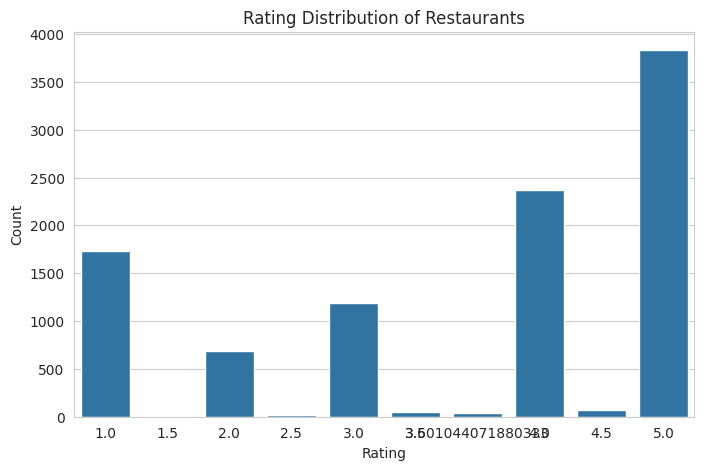

In [ ]:
plt.figure(figsize=(8, 5))
sns.countplot(data=merged_df, x='Rating', order=sorted(merged_df['Rating'].unique()))
plt.title('Rating Distribution of Restaurants')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()


In [ ]:
merged_df['Rating'] = pd.to_numeric(merged_df['Rating'], errors='coerce')

<ipython-input-18-f1ddd5badbee>:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Avg_Rating"].fillna(df["Avg_Rating"].mean(), inplace=True)


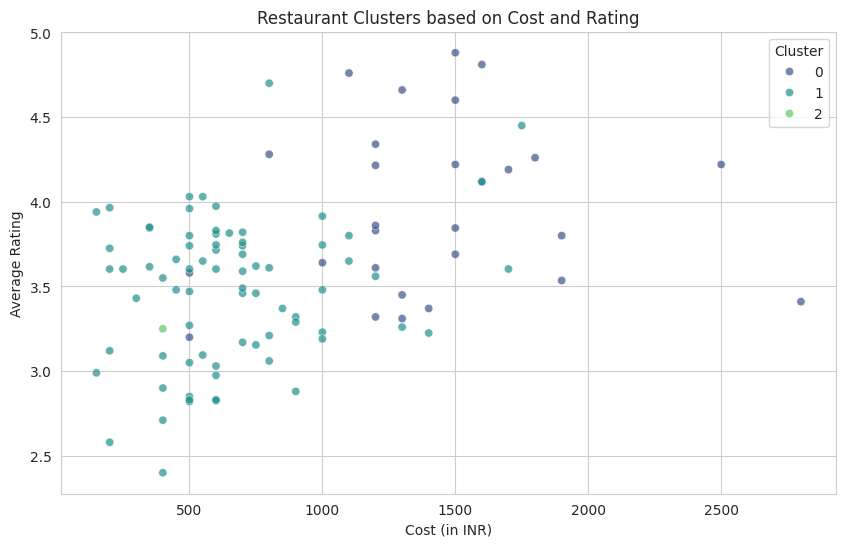

                             Name    Cost  Avg_Rating  \
0                 Beyond Flavours   800.0       4.280   
1                        Paradise   800.0       4.700   
2                        Flechazo  1300.0       4.660   
3  Shah Ghouse Hotel & Restaurant   800.0       3.210   
4      Over The Moon Brew Company  1200.0       4.340   
5           The Fisherman's Wharf  1500.0       4.220   
6                         eat.fit   500.0       3.200   
7        Shah Ghouse Spl Shawarma   300.0       3.430   
8                     Hyper Local  1000.0       3.640   
9                     Cream Stone   350.0       3.845   

                                            Cuisines  Cluster  
0  [Chinese, Continental, Kebab, European, South ...        0  
1                   [Biryani, North Indian, Chinese]        1  
2     [Asian, Mediterranean, North Indian, Desserts]        0  
3  [Biryani, North Indian, Chinese, Seafood, Beve...        1  
4  [Asian, Continental, North Indian, Chinese, Me...

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from sklearn.cluster import KMeans

# Load the datasets
file_path = "/content/Zomato Restaurant names and Metadata (1).csv"
file_path_reviews = "/content/Zomato Restaurant reviews (2).csv"
df = pd.read_csv(file_path)
df_reviews = pd.read_csv(file_path_reviews)

# Clean the 'Cost' column by removing commas and converting to numeric
df["Cost"] = df["Cost"].astype(str).str.replace(",", "").astype(float)

# Fill missing values
df["Collections"] = df["Collections"].fillna("")
df["Timings"] = df["Timings"].fillna("Unknown")

# Convert 'Cuisines' and 'Collections' into list format for multi-label binarization
df["Cuisines"] = df["Cuisines"].str.split(", ")
df["Collections"] = df["Collections"].str.split(", ")

# Convert 'Rating' to numeric, handling missing values
df_reviews["Rating"] = pd.to_numeric(df_reviews["Rating"], errors="coerce")

# Aggregate the average rating per restaurant
df_avg_rating = df_reviews.groupby("Restaurant")["Rating"].mean().reset_index()
df_avg_rating.rename(columns={"Restaurant": "Name", "Rating": "Avg_Rating"}, inplace=True)

# Merge with the original dataset
df = df.merge(df_avg_rating, on="Name", how="left")

# Fill missing ratings with the average rating across all restaurants
df["Avg_Rating"].fillna(df["Avg_Rating"].mean(), inplace=True)

# Apply one-hot encoding using MultiLabelBinarizer
mlb_cuisines = MultiLabelBinarizer()
mlb_collections = MultiLabelBinarizer()

cuisine_encoded = pd.DataFrame(mlb_cuisines.fit_transform(df["Cuisines"]), columns=mlb_cuisines.classes_)
collection_encoded = pd.DataFrame(mlb_collections.fit_transform(df["Collections"]), columns=mlb_collections.classes_)

# Combine encoded features with 'Cost' and 'Avg_Rating'
df_cluster = pd.concat([df[["Cost", "Avg_Rating"]], cuisine_encoded, collection_encoded], axis=1)

# Standardize numerical features
scaler = StandardScaler()
df_cluster_scaled = scaler.fit_transform(df_cluster)

# Apply K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df["Cluster"] = kmeans.fit_predict(df_cluster_scaled)

# Visualize clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="Cost", y="Avg_Rating", hue=df["Cluster"].astype(str), palette="viridis", alpha=0.7)
plt.xlabel("Cost (in INR)")
plt.ylabel("Average Rating")
plt.title("Restaurant Clusters based on Cost and Rating")
plt.legend(title="Cluster")
plt.grid(True)
plt.show()

# Display clustered results
print(df[["Name", "Cost", "Avg_Rating", "Cuisines", "Cluster"]].head(10))

In [ ]:
def recommend_best_restaurants(cuisine_preferences, budget, min_rating=4.0):
    # Create a regex pattern to match multiple cuisines with global flag at the start
    cuisine_regex = '(?i)' + '|'.join([cuisine for cuisine in cuisine_preferences])

    # Filter restaurants based on cuisine, budget, and minimum rating
    # Removing Sentiment filtering as the column doesn't exist
    recommendations = merged_df[
        (merged_df['Cuisines'].str.contains(cuisine_regex, na=False)) &
        (merged_df['Cost'] <= budget) &
        (merged_df['Rating'].astype(float) >= min_rating)
    ]

    # Sort by Rating and Cost to get the best ones
    recommendations = recommendations[['Restaurant', 'Rating', 'Cost', 'Cuisines', 'Timings']].drop_duplicates()  # Removed 'Sentiment'
    recommendations = recommendations.sort_values(by=['Rating', 'Cost'], ascending=[False, True])
    return recommendations.head(10)

# Example usage
print("Best recommendations for North Indian and Chinese cuisines within a budget of 1000:")
print(recommend_best_restaurants(['North Indian', 'Chinese'], 1000))

Best recommendations for North Indian and Chinese cuisines within a budget of 1000:
                    Restaurant  Rating   Cost  \
1001  Sardarji's Chaats & More     5.0  400.0   
1701          Hotel Zara Hi-Fi     5.0  400.0   
1911             Pakwaan Grand     5.0  400.0   
9507                Desi Bytes     5.0  400.0   
9801                  Triptify     5.0  400.0   
2001                  13 Dhaba     5.0  450.0   
5701              Being Hungry     5.0  450.0   
609                    eat.fit     5.0  500.0   
3701       Kritunga Restaurant     5.0  500.0   
4804            Udipi's Upahar     5.0  500.0   

                                               Cuisines  \
1001               Street Food, North Indian, Fast Food   
1701                              Chinese, North Indian   
1911                     North Indian, Chinese, Biryani   
9507                              North Indian, Chinese   
9801                                       North Indian   
2001                  